# Drafting a Figure 3

__Jonah Shaw, 2022/03/04__

Observations show large increases in spring OLR despite the largest temperature increases occurring in the spring. We ask, is observed spring OLR consistent with variability present in the CESM1-LE?

Despite the OLR increases being concentrated in spectral bands heavily weighted towards the surface, we have to use broadband values if we want to compare with the model. This might muddy the signal if there is variability to do other climate processes (SSW events in the late winter).

_I will:_  

1) Plot observed OLR from CERES and AIRS, as well as AIRS spectral bands associated with the spring OLR changes that we are investigating. If I want I could also plot observed OLR just without CO2 bands from AIRS, and a fabricated CERES-AIRS value (subtract AIRS CO2 band values from the CERES OLR).

2) Add the OLR from this period from the CESM1-LE ensemble mean.

3) Add individual OLRs from each member of the CESM1-LE.

In [1]:
# from dask.distributed import Client

# client = Client()
# # client = Client("tcp://127.0.0.1:43033")
# client

Client Scheduler: tcp://127.0.0.1:44931 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jonahshaw/proxy/{port}/status,Cluster Workers: 1 Cores: 1 Memory: 4.29 GB


### Do imports

In [42]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

## Define functions

#### Let's focus on the central Arctic for now (70-90N)

### Load and process CERES observations.

I am using files from Brian Medeiros (most recent, somehow processed)

In [2]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)
ceres_files.sort()

In [3]:
# ceres_subset = arc_subset('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir,var='OLR')

ceres_ds = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir)      
ceres_subset = ceres_ds['OLR'].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))

ceres_ds.close()

Turn the CERES data into a timeseries

In [6]:
ceres_subset_wgtd = add_weights(ceres_subset) # add area-weighting coordinate
ceres_subset_spatavg = ceres_subset_wgtd.weighted(ceres_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])

ceres_subset.close()
ceres_subset_wgtd.close()
ceres_subset_spatavg.close()

### Load and process AIRS observations.

In [8]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
airs_broadband_olr = add_weights(xr.open_dataset('%s/%s/olr_broadband.nc' % (airs_dir,'arc_proc/')))

In [9]:
# Subset data so computations are lighter and significance tests make sense
airs_subset_interp = airs_broadband_olr['olr'].interp_like(ceres_subset.isel(time=0))
airs_broadband_olr.close()

airs_subset = airs_subset_interp.sel(time=slice('2003-01-01','2019-12-31'),lat=slice(69,90)).mean(dim=['orbit_pass'])
airs_subset_interp.close()

# airs_subset = airs_broadband_olr['olr'].sel(time=slice('2003-01-01','2019-12-31'),lat=slice(69,90)).mean(dim=['orbit_pass'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
airs_subset_wgtd = add_weights(airs_subset)
airs_subset_spatavg = airs_subset_wgtd.weighted(airs_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])
# airs_subset_spatavg = masked_average(airs_subset_wgtd,dim=['lat','lon'],weights=airs_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO

airs_subset_wgtd.close()

### Load Berkeley BEST data

Berkeley Earth Surface Temperatures (BEST).

Haven't used this before. Was suggested by Jen/Dave.

http://berkeleyearth.org/data/

In [38]:
best_path = '/glade/work/jonahshaw/obs/BEST/'
best_file = 'Land_and_Ocean_LatLong1.nc'

In [39]:
best_temp = xr.open_dataset('%s/%s' % (best_path,best_file)).rename({'latitude':'lat','longitude':'lon'})

The time format is annoying. I will need to fix this.

In [43]:
# One-line command just creates values at the end of each month (functional by potentially confusing)
# times = pd.date_range("1850/01/01","2021/12/31",freq='1M',closed=None)

# Manual code w/ for loops :(
years = np.arange(1850,2021.1,1)
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

# manually create the time strings
time_str_list = []

for _yr in years: # Create list of time-string objects
    for _mnth in months:
        _new_str = '%s-%s-15' % (int(_yr),_mnth)
        time_str_list.append(_new_str)
        
times = pd.to_datetime(time_str_list) # turn into a pandas object
time_da = xr.DataArray(times, [('time', times)]) # turn into an xarray object

In [44]:
# Assign the new time coordinate
best_temp_timefixed = best_temp.assign_coords({'time':time_da})

__Process BEST data__

In [52]:
besttemp_wgtd = add_weights(best_temp_timefixed)
best_temp_timefixed.close()

In [51]:
# Subset data so computations are lighter and significance tests make sense
besttemp_subset_interp = besttemp_wgtd['temperature'].interp_like(ceres_subset.isel(time=0))
besttemp_wgtd.close()

besttemp_subset = besttemp_subset_interp.sel(time=slice('2001-01-01','2050-12-31'),lat=slice(69,90))
besttemp_subset_interp.close()

In [53]:
besttemp_subset_wgtd = add_weights(besttemp_subset)
besttemp_subset_spatavg = besttemp_subset_wgtd.weighted(besttemp_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])

besttemp_subset_wgtd.close()

### Format and select CESM1 ensemble average data

In [14]:
ensavg_path = '/glade/work/jonahshaw/LENS/CESM1-LE/EnsAvg/'

In [16]:
ensavg_olr_files = glob.glob('%s/*%s*.nc' % (ensavg_path,'FLUT')) # get appropriate files

ensavg_olr_ds = xr.open_mfdataset(ensavg_olr_files)

ensavg_interp = ensavg_olr_ds['FLUT'].interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF
ensavg_olr_ds.close() # probably not needed since it is a dask array

ensavg_subset = ensavg_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None)).chunk({'time':-1})
ensavg_interp.close()

ensavg_subset_wgtd = add_weights(ensavg_subset) # add area-weighting coordinate
ensavg_subset_spatavg = ensavg_subset_wgtd.weighted(ensavg_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])
# ensavg_subset_spatavg = masked_average(ensavg_subset_wgtd,dim=['lat','lon'],weights=ensavg_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO

# ensavg_subset_monavg = ensavg_subset_spatavg.groupby('time.month').mean('time').compute() #.chunk({'month':-1}) # monthly OLR averages over the CERES record

ensavg_subset.close()
ensavg_subset_wgtd.close()
# ensavg_subset_spatavg.close()

In [17]:
ensavg_ts_files = glob.glob('%s/*%s*.nc' % (ensavg_path,'TS')) # get appropriate files

ensavg_ts_ds = xr.open_mfdataset(ensavg_ts_files)

ensavg_ts_interp = ensavg_ts_ds['TS'].interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF
ensavg_ts_ds.close() # probably not needed since it is a dask array

ensavg_ts_subset = ensavg_ts_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None)).chunk({'time':-1})
ensavg_ts_interp.close()

ensavg_ts_subset_wgtd = add_weights(ensavg_ts_subset) # add area-weighting coordinate
ensavg_ts_subset_spatavg = ensavg_subset_wgtd.weighted(ensavg_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])

ensavg_ts_subset.close()
ensavg_ts_subset_wgtd.close()

### Iterate over CESM1 RCP8.5 ensemble members and variables of interest

In [19]:
cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

In [20]:
# hardcoded alternate with only ensembles we can use
ensemble_nums = [
    '001', '002', '003', '004', '005', 
    '006', '007', '008', '009', '010',
    '011', '012', '013', '014', '015',
    '016', '017', '018', '019', '020',
    '021', '022', '023', '024', '025', 
    '026', '027', '028', '029', '030', 
    '031', '032', '033', '034', '035', 
    '101', '102', '103', '104', '105'
]

#### Collect all paths in a dictionary

In [21]:
path_dict = {} # key is the ensemble number
_var = 'FLUT'

for _ensn in ensemble_nums:
    _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.1??001-200512.nc' % (cesmle_path,_var,_ensn,_var))
    _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

    if (len(_t1_file) != 1) or (len(_t2_file) != 1):
        print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
        break
    # try:
    path_dict[_ensn] = [*_t1_file,*_t2_file]
    # except:
    #     path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

In [22]:
var_dict = {} # key is the ensemble number
ens_vars = ['FLUT','TS']

for _var in ens_vars:
    _path_dict = {}
    for _ensn in ensemble_nums:
        _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.1??001-200512.nc' % (cesmle_path,_var,_ensn,_var))
        _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

        if (len(_t1_file) != 1) or (len(_t2_file) != 1):
            print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
            break

        _path_dict[_ensn] = [*_t1_file,*_t2_file]
    var_dict[_var] = _path_dict
    
    # except:
    #     path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

#### Collect paths for the PI-control run for each variable

In [58]:
pi_path_dict = {}
ens_vars = ['FLUT','TS']

for _var in ens_vars:
    'b.e11.B1850C5CN.f09_g16.005'
    _pi_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesmle_path,_var))    
    
    pi_path_dict[_var] = _pi_files

#### Calculate an Arctic timeseries for each member in the CESM1-LE (for each variable of interest)

This is much faster now, <2s per ensemble member. Could be really fast if I figured out how to use Dask here.

In [30]:
%%time

ens_vars = ['FLUT','TS']
allens_var_dict = {}

for _var in ens_vars:
    print(_var)
    _path_dict = var_dict[_var]
    ens_var_tseries_dict = {} # dictionary for all the data for a single variable

    for _ens_num in ensemble_nums: # iterate over ensemble members
        print(_ens_num,end=' ')

        _ens_var_files = _path_dict[_ens_num]

        _ens_var_ds = fix_cesm_time(xr.open_mfdataset(_ens_var_files))[_var].chunk({'lat':-1,'lon':-1}) # chunk to prep for lat-lon interpolation

        _ens_interp = _ens_var_ds.interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF
        _ens_var_ds.close()

        _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2050-12-31'),lat=slice(69,None))
        # _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))
        _ens_interp.close()

        _ens_subset_wgtd = add_weights(_ens_subset) # add area-weighting coordinate
        _ens_subset.close()

        _ens_subset_spatavg = _ens_subset_wgtd.weighted(_ens_subset_wgtd['cell_weight']).mean(dim=['lat','lon']) # use xarray builtin weighting
        _ens_subset_wgtd.close()
        _ens_subset_spatavg = _ens_subset_spatavg.compute() # this might speed things up since everything goes through this object
        _ens_subset_spatavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining

        ens_var_tseries_dict[_ens_num] = _ens_subset_spatavg

        # if _ens_num == '005':break

    allens_all_tseries = xr.concat(list(ens_var_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
    allens_var_dict[_var] = allens_all_tseries

# allens_mon_tseries = allens_all_tseries.groupby('time.month').mean('time')

FLUT
001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 101 102 103 104 105 TS
001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 101 102 103 104 105 CPU times: user 2min 16s, sys: 1min 1s, total: 3min 18s
Wall time: 4min 15s


#### Calculate an Arctic timeseries for the CESM1-LE PI-Control simulations (for each variable of interest)

In [165]:
%%time

ens_vars = ['FLUT','TS']
pic_var_dict = {}

for _var in ens_vars:
    print(_var)
    # Open all the PI-Control data
    pi_bigds = xr.open_mfdataset(pi_path_dict[_var],parallel=True) 
    # Fix the time coordinate, subset the Arctic, and add weights
    pi_subset = fix_cesm_time(pi_bigds)[_var].sel(lat=slice(65,None)).chunk({'lat':-1,'lon':-1})
    pi_bigds.close()
    
    # Interpolate to the CERES central Arctic
    pi_interp = add_weights(pi_subset.interp_like(ceres_subset.isel(time=0)))
    pi_subset.close()
    
    # Perform an area-weighted average and rechunk to put into a timeseries.
    pi_tseries = pi_interp.weighted(pi_interp['cell_weight']).mean(dim=['lat','lon'])
    pi_tseries_clean = pi_tseries.chunk({'time':-1})
    pi_interp.close()
    pi_tseries.close()
    
    pic_var_dict[_var] = pi_tseries_clean.compute() # compute and save appropriately, takes surprisingly long

FLUT
TS
CPU times: user 45.3 s, sys: 16.2 s, total: 1min 1s
Wall time: 1min 20s


#### Reformat the PI-Control timeseries into an ensemble-like format for a given member length.

In [180]:
tlength = 50
nmembers = 40

month_increment = tlength*12 # length of the timeseries

pic_final_dict = {}
for _var in pic_var_dict:
    print(_var)

    pic_tseries_dict = {}

    for mem_n in range(nmembers):
        # Define index start and endpoints
        start_index = mem_n*month_increment
        end_index = start_index + month_increment
        
        if end_index > len(pic_var_dict[_var].time):
            print('Cannot fit %d non-overlapping ensemble members of %d years in the available data. Returning %d members.' % (nmembers,tlength,mem_n))
            break
        sub_tseries = pic_var_dict[_var].isel(time=slice(start_index,end_index))

        # print(sub_tseries.time) # test code demonstrates non-overlapping t-series

        # create a fake timeseries so that we can combine these fake ensemble members
        # timeseries must be between print(pd.Timestamp.min) and print(pd.Timestamp.max) 1677 and 2262 roughly. I am just starting mine at 1700 so they are obviously PI
        new_times = pd.date_range('1700/01/01',freq='1M',periods=month_increment,closed=None) 
        new_times_da = xr.DataArray(new_times, [('time', new_times)]) # turn into an xarray object
        sub_tseries_timefixed = sub_tseries.assign_coords({'time':new_times_da})

        sub_tseries_timefixed['ens'] = mem_n # add ensemble coordinate for easy combining

        pic_tseries_dict[str(mem_n)] = sub_tseries_timefixed

        # if mem_n == 2:
        #     break

    pic_all_tseries = xr.concat(list(pic_tseries_dict.values()),dim='ens')
    
    pic_final_dict[_var] = pic_all_tseries

FLUT
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.
TS
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.


In [181]:
def pi_tseries_to_ens(pi_var_dict,tlength,nmembers):
    
    month_increment = tlength*12 # length of the timeseries

    pic_final_dict = {}
    for _var in pic_var_dict: # iterate over keys, which are the variables
        print(_var)

        pic_tseries_dict = {}

        for mem_n in range(nmembers):
            # Define index start and endpoints
            start_index = mem_n*month_increment
            end_index = start_index + month_increment

            if end_index > len(pic_var_dict[_var].time):
                print('Cannot fit %d non-overlapping ensemble members of %d years in the available data. Returning %d members.' % (nmembers,tlength,mem_n))
                break
            sub_tseries = pic_var_dict[_var].isel(time=slice(start_index,end_index))

            # print(sub_tseries.time) # test code demonstrates non-overlapping t-series

            # create a fake timeseries so that we can combine these fake ensemble members
            # timeseries must be between print(pd.Timestamp.min) and print(pd.Timestamp.max) 1677 and 2262 roughly. I am just starting mine at 1700 so they are obviously PI
            new_times = pd.date_range('1700/01/01',freq='1M',periods=month_increment,closed=None) 
            new_times_da = xr.DataArray(new_times, [('time', new_times)]) # turn into an xarray object
            sub_tseries_timefixed = sub_tseries.assign_coords({'time':new_times_da})

            sub_tseries_timefixed['ens'] = mem_n # add ensemble coordinate for easy combining

            pic_tseries_dict[str(mem_n)] = sub_tseries_timefixed

            # if mem_n == 2:
            #     break

        pic_all_tseries = xr.concat(list(pic_tseries_dict.values()),dim='ens')

        pic_final_dict[_var] = pic_all_tseries
    
    return pic_final_dict

### Now plot box-and-whisker plots for different end years

In [31]:
endyrs   = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
startyrs = [2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011]

In [32]:
def tick_function1(X):
    out = ["%.0f" % z for z in X]
    return out

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def box_n_whisker_endyear(lens_tseries,obs_tseries,iter_yrs:list,iteryr_isstart:bool,ylabel,obslabel,ax=None,**kwargs):
    
    if not ax:
        box_fig,box_ax = plt.subplots(1,1,figsize=(8,8)) # create your own axis if not supplied
    else:
        box_ax = ax

    obs_slopes = []
    lens_slopes_dict = {}

    # for _yr in endyrs:
    for _yr in iter_yrs:
        # check if the provided years are a start or endyear, handle appropriately
        if iteryr_isstart:
            obs_tseries_concated  = obs_tseries.sel(year=slice(_yr,None))
            lens_tseries_concated = lens_tseries.sel(year=slice(_yr,None))
        else:
            obs_tseries_concated  = obs_tseries.sel(year=slice(None,_yr))
            lens_tseries_concated = lens_tseries.sel(year=slice(None,_yr))

        obs_polyfit  = obs_tseries_concated.polyfit(dim='year',deg=1)
        lens_polyfit = lens_tseries_concated.polyfit(dim='year',deg=1)

        obs_slope   = obs_polyfit['polyfit_coefficients'].sel(degree=1).values
        lens_slopes = lens_polyfit['polyfit_coefficients'].sel(degree=1).values

        if _yr not in obs_tseries['year']: # check if we've reached the end of the obs. period
            obs_slope = None
        obs_slopes.append(obs_slope)
        lens_slopes_dict[_yr] = lens_slopes

    # Plot a reference line for the median slope of the longest record
    box_ax.hlines(np.median(lens_slopes_dict[_yr]),0.5,len(iter_yrs)+0.5,linestyle='dashed',linewidth=1,color='grey') # xlims were *box_ax.get_xlim()
    box_out = box_ax.boxplot(lens_slopes_dict.values(), labels=iter_yrs,**kwargs)
    box_ax.scatter(np.arange(1,len(iter_yrs)+1,1),obs_slopes,label=obslabel,marker='*',color='yellow',edgecolors= "black",s=150) # update label here
        
    if iteryr_isstart: # Label the x-axis correctly
        xlabel = 'Trend Start Year'
    else:
        xlabel = 'Trend End Year'
        
    box_ax.set_xlabel(xlabel,fontsize=13)
    box_ax.set_ylabel(ylabel,fontsize=13) # fix

    box_axb = box_ax.twiny() 
    # Twinning the axis doesn't copy over everything apparently. Need to copy tick values.
    box_axb.set_xlim(box_ax.get_xlim())
    box_axb.set_xticks(box_ax.get_xticks())

    # Handle being able to pass either start or end years
    if iteryr_isstart:
        startyr = np.array(iter_yrs)
        endyr = int(obs_tseries.isel(year=-1)['year'])
    else:
        startyr = int(obs_tseries.isel(year=0)['year'])
        endyr = np.array(iter_yrs)
        
    box_ax.set_xticklabels(iter_yrs,rotation=45)
    box_axb.set_xticklabels(tick_function1(1 + endyr - startyr))
    box_axb.set_xlabel('Trend Duration (yrs)',fontsize=13)

    box_ax.set_ylim(-1.25,1.25)
    
    box_ax.legend()
    
    # return box_out,
    

def linear_polyfit(ds):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1))
    '''
    ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right
    
    return ds.polyfit(dim='time',deg=1)


def box_n_whisker_allmonths(lens_tseries,obs_tseries,ylabel:str,obslabel:str,ax=None,**kwargs):
    '''
    Function to produce boxplots showing ensemble spread for all months.
    '''
    
    month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
    if not ax:
        box_fig,box_ax = plt.subplots(1,1,figsize=(8,8)) # create your own axis if not supplied
    else:
        box_ax = ax

    obs_slopes = []
    lens_slopes_dict = {}
    
    # Run a linear fit for each month for each ensemble member
    ens_linfit = lens_tseries.groupby('time.month').map(linear_polyfit)
    obs_linfit = obs_tseries.groupby('time.month').map(linear_polyfit)
    
    ens_slopes = ens_linfit['polyfit_coefficients'].sel(degree=1)#.values
    obs_slopes = obs_linfit['polyfit_coefficients'].sel(degree=1)#.values

    box_out = box_ax.boxplot(ens_slopes, labels=month_labels, **kwargs) #labels=iter_yrs,
    box_ax.scatter(np.arange(1,13,1),obs_slopes,label=obslabel,marker='*',color='yellow',edgecolors= "black",s=150) # update label here
                
    box_ax.set_xlabel('Month',fontsize=13)
    box_ax.set_ylabel(ylabel,fontsize=13) # fix
    
    box_ax.set_ylim((-0.2,0.6))
    
    box_ax.legend()

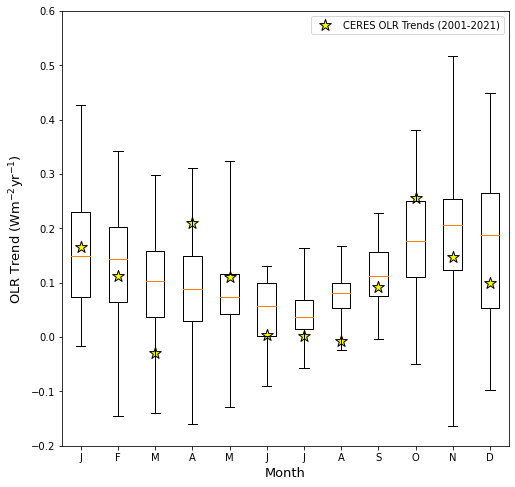

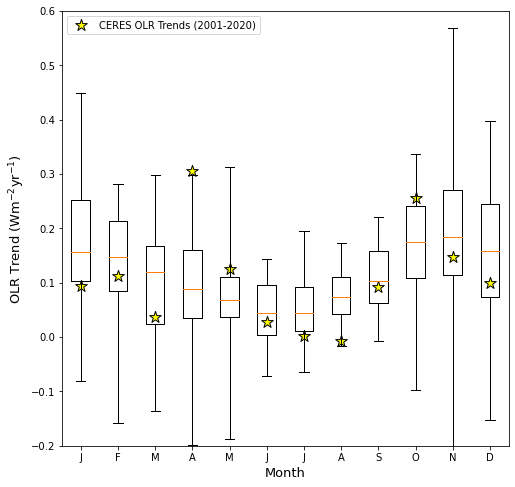

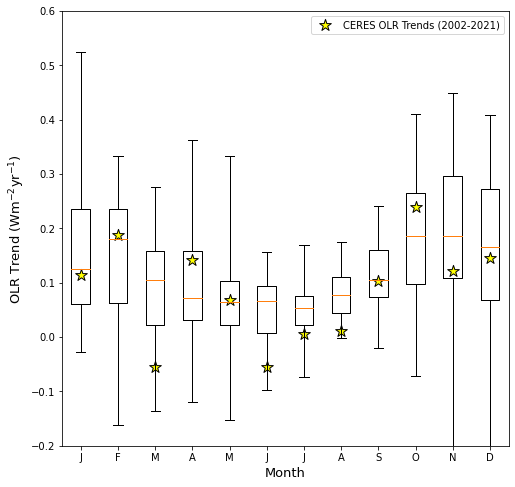

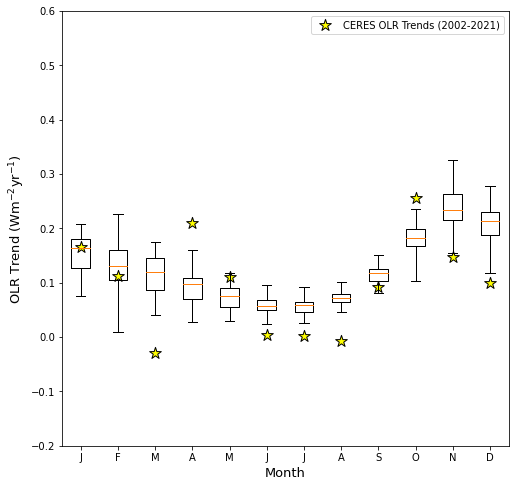

In [33]:
allens_all_tseries = allens_var_dict['FLUT']

tsel_2001_2021 = slice('2001-01-01','2021-12-31')
tsel_2001_2020 = slice('2001-01-01','2020-12-31')
tsel_2002_2021 = slice('2002-01-01','2021-12-31')
tsel_2002_2050 = slice('2001-01-01','2050-12-31')

box_n_whisker_allmonths(allens_all_tseries.sel(time=tsel_2001_2021),
                        ceres_subset_spatavg.sel(time=tsel_2001_2021),
                        ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                        obslabel='CERES OLR Trends (2001-2021)',
                        whis=(0,100),
                       )

box_n_whisker_allmonths(allens_all_tseries.sel(time=tsel_2001_2020),
                        ceres_subset_spatavg.sel(time=tsel_2001_2020),
                        ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                        obslabel='CERES OLR Trends (2001-2020)',
                        whis=(0,100),
                       )

box_n_whisker_allmonths(allens_all_tseries.sel(time=tsel_2002_2021),
                        ceres_subset_spatavg.sel(time=tsel_2002_2021),
                        ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                        obslabel='CERES OLR Trends (2002-2021)',
                        whis=(0,100),
                       )

box_n_whisker_allmonths(allens_all_tseries.sel(time=tsel_2002_2050),
                        ceres_subset_spatavg.sel(time=tsel_2002_2050),
                        ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                        obslabel='CERES OLR Trends (2002-2021)',
                        whis=(0,100),
                       )

### Show multiple cases on a single plot

FLUT
TS
FLUT
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.
TS
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.


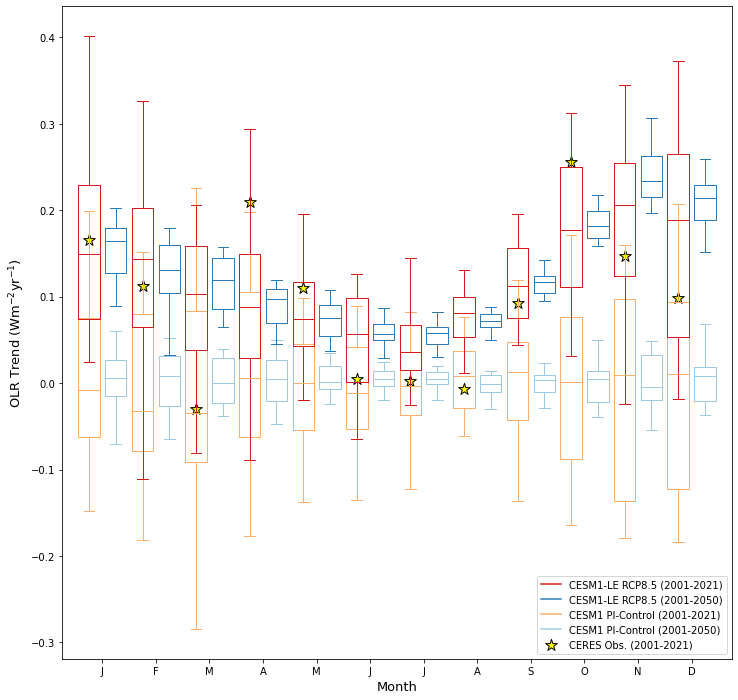

In [209]:
# Raw timeseries data
lens_tseries = allens_var_dict['FLUT']
obs_tseries = ceres_subset_spatavg

# Calculate PI-Control timeseries
pic_tseries_2021 = pi_tseries_to_ens(pic_var_dict,tlength=21,nmembers=40)['FLUT']
pic_tseries_2050 = pi_tseries_to_ens(pic_var_dict,tlength=50,nmembers=40)['FLUT']

tsel_2021 = slice('2001-01-01','2021-12-31')
tsel_2050 = slice('2001-01-01','2050-12-31')

lens_tseries_2021 = lens_tseries.sel(time=tsel_2021)
lens_tseries_2050 = lens_tseries.sel(time=tsel_2050)
obs_tseries_2021 = obs_tseries.sel(time=tsel_2021)

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
box_fig,box_ax = plt.subplots(1,1,figsize=(12,12)) # create your own axis if not supplied

obs_slopes_2021 = []
lens_slopes_dict_2021 = {}
lens_slopes_dict_2050 = {}
pic_slopes_dict_2021 = {}
pic_slopes_dict_2050 = {}

# Run a linear fit for each month for each ensemble member
ens_linfit_2021 = lens_tseries_2021.groupby('time.month').map(linear_polyfit)
ens_linfit_2050 = lens_tseries_2050.groupby('time.month').map(linear_polyfit)
pic_linfit_2021 = pic_tseries_2021.groupby('time.month').map(linear_polyfit)
pic_linfit_2050 = pic_tseries_2050.groupby('time.month').map(linear_polyfit)
obs_linfit_2021 = obs_tseries_2021.groupby('time.month').map(linear_polyfit)

ens_slopes_2021 = ens_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2050 = ens_linfit_2050['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2021 = pic_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2050 = pic_linfit_2050['polyfit_coefficients'].sel(degree=1)#.values
obs_slopes_2021 = obs_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values

# Plot the model distributions as boxplots

# Start with PI-Control
# box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(5,95),showfliers=False)
box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(5,95),showfliers=False)

set_box_color(box_pic_2021,'#FDAE6B')
set_box_color(box_pic_2050,'#9ECAE1')

# Now do RCP8.5
# box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(5,95),showfliers=False)
box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(5,95),showfliers=False)

set_box_color(box_ens_2021, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(box_ens_2050, '#2C7BB6')

# Plot observations as a scatterplot
box_ax.scatter(np.arange(1,13,1)-0.25,obs_slopes_2021,label='CERES Obs. (2001-2021)',marker='*',color='yellow',edgecolors= "black",s=150) # update label here

box_ax.set_xlabel('Month',fontsize=13)
box_ax.set_ylabel('OLR Trend (Wm$^{-2}$yr$^{-1}$)',fontsize=13) # fix

box_ax.set_xticks(np.arange(1,13,1))
box_ax.set_xticklabels(month_labels)
# box_ax.set_ylim((-0.2,0.6))

# draw temporary red and blue lines and use them to create a legend
box_ax.plot([], c='#D7191C', label='CESM1-LE RCP8.5 (2001-2021)')
box_ax.plot([], c='#2C7BB6', label='CESM1-LE RCP8.5 (2001-2050)')

box_ax.plot([], c='#FDAE6B', label='CESM1 PI-Control (2001-2021)') 
box_ax.plot([], c='#9ECAE1', label='CESM1 PI-Control (2001-2050)')

box_ax.legend()

FLUT
TS
FLUT
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.
TS
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.


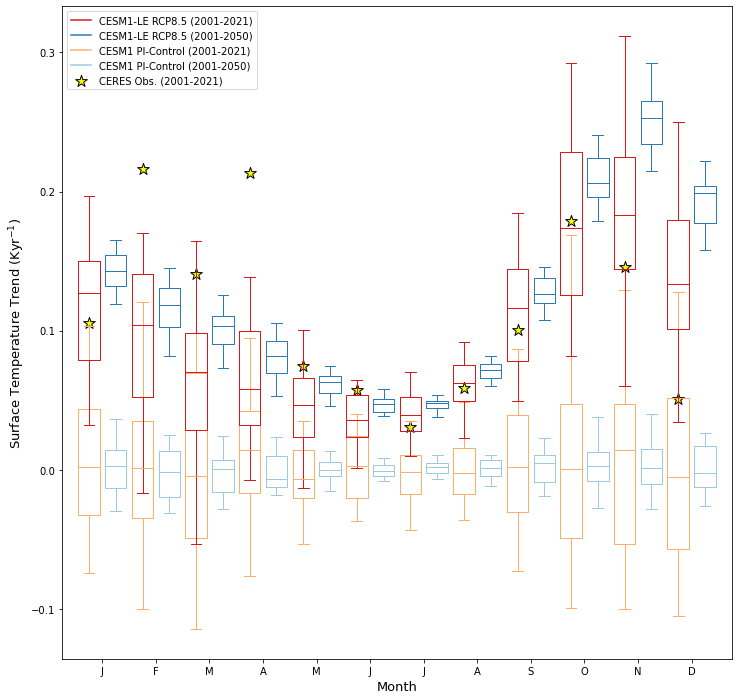

In [208]:
# Raw timeseries data
lens_tseries = allens_var_dict['TS']
obs_tseries = besttemp_subset_spatavg

# Calculate PI-Control timeseries
pic_tseries_2021 = pi_tseries_to_ens(pic_var_dict,tlength=21,nmembers=40)['TS']
pic_tseries_2050 = pi_tseries_to_ens(pic_var_dict,tlength=50,nmembers=40)['TS']

tsel_2021 = slice('2001-01-01','2021-12-31')
tsel_2050 = slice('2001-01-01','2050-12-31')

lens_tseries_2021 = lens_tseries.sel(time=tsel_2021)
lens_tseries_2050 = lens_tseries.sel(time=tsel_2050)
obs_tseries_2021 = obs_tseries.sel(time=tsel_2021)

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
box_fig,box_ax = plt.subplots(1,1,figsize=(12,12)) # create your own axis if not supplied

obs_slopes_2021 = []
lens_slopes_dict_2021 = {}
lens_slopes_dict_2050 = {}
pic_slopes_dict_2021 = {}
pic_slopes_dict_2050 = {}

# Run a linear fit for each month for each ensemble member
ens_linfit_2021 = lens_tseries_2021.groupby('time.month').map(linear_polyfit)
ens_linfit_2050 = lens_tseries_2050.groupby('time.month').map(linear_polyfit)
pic_linfit_2021 = pic_tseries_2021.groupby('time.month').map(linear_polyfit)
pic_linfit_2050 = pic_tseries_2050.groupby('time.month').map(linear_polyfit)
obs_linfit_2021 = obs_tseries_2021.groupby('time.month').map(linear_polyfit)

ens_slopes_2021 = ens_linfit_2021['polyfit_coefficients'].sel(degree=1)
ens_slopes_2050 = ens_linfit_2050['polyfit_coefficients'].sel(degree=1)
pic_slopes_2021 = pic_linfit_2021['polyfit_coefficients'].sel(degree=1)
pic_slopes_2050 = pic_linfit_2050['polyfit_coefficients'].sel(degree=1)
obs_slopes_2021 = obs_linfit_2021['polyfit_coefficients'].sel(degree=1)

# Plot the model distributions as boxplots

# Start with PI-Control
# box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100)) 
# box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(5,95),showfliers=False)
box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(5,95),showfliers=False)

set_box_color(box_pic_2021,'#FDAE6B')
set_box_color(box_pic_2050,'#9ECAE1')

# Now do RCP8.5
# box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(5,95),showfliers=False)
box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(5,95),showfliers=False)

set_box_color(box_ens_2021, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(box_ens_2050, '#2C7BB6')

# Plot observations as a scatterplot
box_ax.scatter(np.arange(1,13,1)-0.25,obs_slopes_2021,label='CERES Obs. (2001-2021)',marker='*',color='yellow',edgecolors= "black",s=150) # update label here

box_ax.set_xlabel('Month',fontsize=13)
box_ax.set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=13) # fix

box_ax.set_xticks(np.arange(1,13,1))
box_ax.set_xticklabels(month_labels)
# box_ax.set_ylim((-0.2,0.6))

# draw temporary red and blue lines and use them to create a legend
box_ax.plot([], c='#D7191C', label='CESM1-LE RCP8.5 (2001-2021)')
box_ax.plot([], c='#2C7BB6', label='CESM1-LE RCP8.5 (2001-2050)')

box_ax.plot([], c='#FDAE6B', label='CESM1 PI-Control (2001-2021)') 
box_ax.plot([], c='#9ECAE1', label='CESM1 PI-Control (2001-2050)')

box_ax.legend()

#### Experiment with different observational lengths

FLUT
TS
FLUT
TS
FLUT
TS
FLUT
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.
TS
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.


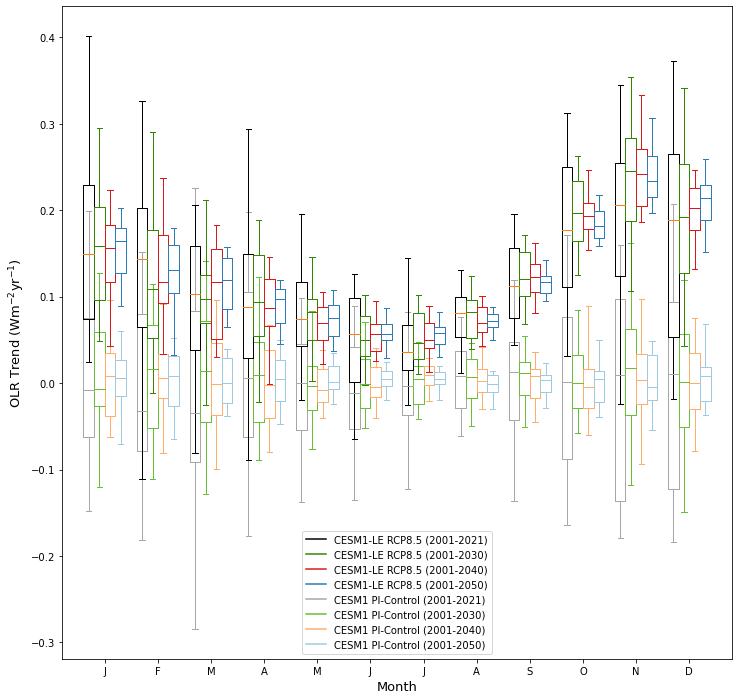

In [215]:
# Raw timeseries data
lens_tseries = allens_var_dict['FLUT']
obs_tseries = ceres_subset_spatavg

# Calculate PI-Control timeseries
pic_tseries_2021 = pi_tseries_to_ens(pic_var_dict,tlength=21,nmembers=40)['FLUT']
pic_tseries_2030 = pi_tseries_to_ens(pic_var_dict,tlength=30,nmembers=40)['FLUT']
pic_tseries_2040 = pi_tseries_to_ens(pic_var_dict,tlength=40,nmembers=40)['FLUT']
pic_tseries_2050 = pi_tseries_to_ens(pic_var_dict,tlength=50,nmembers=40)['FLUT']

tsel_2021 = slice('2001-01-01','2021-12-31')
tsel_2030 = slice('2001-01-01','2030-12-31')
tsel_2040 = slice('2001-01-01','2040-12-31')
tsel_2050 = slice('2001-01-01','2050-12-31')

lens_tseries_2021 = lens_tseries.sel(time=tsel_2021)
lens_tseries_2030 = lens_tseries.sel(time=tsel_2030)
lens_tseries_2040 = lens_tseries.sel(time=tsel_2040)
lens_tseries_2050 = lens_tseries.sel(time=tsel_2050)
obs_tseries_2021 = obs_tseries.sel(time=tsel_2021)

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
box_fig,box_ax = plt.subplots(1,1,figsize=(12,12)) # create your own axis if not supplied

obs_slopes_2021 = []
lens_slopes_dict_2021 = {}
lens_slopes_dict_2030 = {}
lens_slopes_dict_2040 = {}
lens_slopes_dict_2050 = {}
pic_slopes_dict_2021 = {}
pic_slopes_dict_2030 = {}
pic_slopes_dict_2040 = {}
pic_slopes_dict_2050 = {}

# Run a linear fit for each month for each ensemble member
ens_linfit_2021 = lens_tseries_2021.groupby('time.month').map(linear_polyfit)
ens_linfit_2030 = lens_tseries_2030.groupby('time.month').map(linear_polyfit)
ens_linfit_2040 = lens_tseries_2040.groupby('time.month').map(linear_polyfit)
ens_linfit_2050 = lens_tseries_2050.groupby('time.month').map(linear_polyfit)
pic_linfit_2021 = pic_tseries_2021.groupby('time.month').map(linear_polyfit)
pic_linfit_2030 = pic_tseries_2030.groupby('time.month').map(linear_polyfit)
pic_linfit_2040 = pic_tseries_2040.groupby('time.month').map(linear_polyfit)
pic_linfit_2050 = pic_tseries_2050.groupby('time.month').map(linear_polyfit)
obs_linfit_2021 = obs_tseries_2021.groupby('time.month').map(linear_polyfit)

ens_slopes_2021 = ens_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2030 = ens_linfit_2030['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2040 = ens_linfit_2040['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2050 = ens_linfit_2050['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2021 = pic_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2030 = pic_linfit_2030['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2040 = pic_linfit_2040['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2050 = pic_linfit_2050['polyfit_coefficients'].sel(degree=1)#.values
obs_slopes_2021 = obs_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values

# Plot the model distributions as boxplots

# Start with PI-Control
# box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.30,widths=0.20,whis=(5,95),showfliers=False)
box_pic_2030 = box_ax.boxplot(pic_slopes_2030,  positions=np.arange(1,13)-0.10,widths=0.20,whis=(5,95),showfliers=False)
box_pic_2040 = box_ax.boxplot(pic_slopes_2040,  positions=np.arange(1,13)+0.10,widths=0.20,whis=(5,95),showfliers=False)
box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.30,widths=0.20,whis=(5,95),showfliers=False)

set_box_color(box_pic_2021,'#A7A7A7')
set_box_color(box_pic_2030,'#66BF34')
set_box_color(box_pic_2040,'#FDAE6B')
set_box_color(box_pic_2050,'#9ECAE1')

# Now do RCP8.5
# box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.30,widths=0.20,whis=(5,95),showfliers=False)
box_ens_2030 = box_ax.boxplot(ens_slopes_2030,  positions=np.arange(1,13)-0.10,widths=0.20,whis=(5,95),showfliers=False)
box_ens_2040 = box_ax.boxplot(ens_slopes_2040,  positions=np.arange(1,13)+0.10,widths=0.20,whis=(5,95),showfliers=False)
box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.30,widths=0.20,whis=(5,95),showfliers=False)

set_box_color(box_ens_2030, '#000000')
set_box_color(box_ens_2030, '#318500')
set_box_color(box_ens_2040, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(box_ens_2050, '#2C7BB6')

# Plot observations as a scatterplot
# box_ax.scatter(np.arange(1,13,1)-0.25,obs_slopes_2021,label='CERES Obs. (2001-2021)',marker='*',color='yellow',edgecolors= "black",s=150) # update label here

box_ax.set_xlabel('Month',fontsize=13)
box_ax.set_ylabel('OLR Trend (Wm$^{-2}$yr$^{-1}$)',fontsize=13) # fix

box_ax.set_xticks(np.arange(1,13,1))
box_ax.set_xticklabels(month_labels)
# box_ax.set_ylim((-0.2,0.6))

# draw temporary red and blue lines and use them to create a legend
box_ax.plot([], c='#000000', label='CESM1-LE RCP8.5 (2001-2021)')
box_ax.plot([], c='#318500', label='CESM1-LE RCP8.5 (2001-2030)')
box_ax.plot([], c='#D7191C', label='CESM1-LE RCP8.5 (2001-2040)')
box_ax.plot([], c='#2C7BB6', label='CESM1-LE RCP8.5 (2001-2050)')

box_ax.plot([], c='#A7A7A7', label='CESM1 PI-Control (2001-2021)')
box_ax.plot([], c='#66BF34', label='CESM1 PI-Control (2001-2030)')
box_ax.plot([], c='#FDAE6B', label='CESM1 PI-Control (2001-2040)')
box_ax.plot([], c='#9ECAE1', label='CESM1 PI-Control (2001-2050)')

box_ax.legend()

FLUT
TS
FLUT
TS
FLUT
TS
FLUT
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.
TS
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.


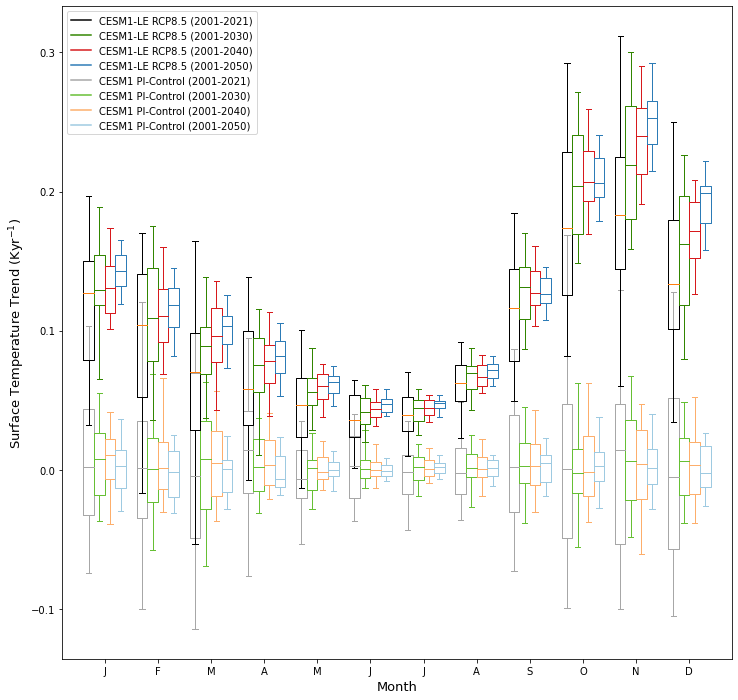

In [217]:
# Raw timeseries data
lens_tseries = allens_var_dict['TS']
obs_tseries = ceres_subset_spatavg

# Calculate PI-Control timeseries
pic_tseries_2021 = pi_tseries_to_ens(pic_var_dict,tlength=21,nmembers=40)['TS']
pic_tseries_2030 = pi_tseries_to_ens(pic_var_dict,tlength=30,nmembers=40)['TS']
pic_tseries_2040 = pi_tseries_to_ens(pic_var_dict,tlength=40,nmembers=40)['TS']
pic_tseries_2050 = pi_tseries_to_ens(pic_var_dict,tlength=50,nmembers=40)['TS']

tsel_2021 = slice('2001-01-01','2021-12-31')
tsel_2030 = slice('2001-01-01','2030-12-31')
tsel_2040 = slice('2001-01-01','2040-12-31')
tsel_2050 = slice('2001-01-01','2050-12-31')

lens_tseries_2021 = lens_tseries.sel(time=tsel_2021)
lens_tseries_2030 = lens_tseries.sel(time=tsel_2030)
lens_tseries_2040 = lens_tseries.sel(time=tsel_2040)
lens_tseries_2050 = lens_tseries.sel(time=tsel_2050)
obs_tseries_2021 = obs_tseries.sel(time=tsel_2021)

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
box_fig,box_ax = plt.subplots(1,1,figsize=(12,12)) # create your own axis if not supplied

obs_slopes_2021 = []
lens_slopes_dict_2021 = {}
lens_slopes_dict_2030 = {}
lens_slopes_dict_2040 = {}
lens_slopes_dict_2050 = {}
pic_slopes_dict_2021 = {}
pic_slopes_dict_2030 = {}
pic_slopes_dict_2040 = {}
pic_slopes_dict_2050 = {}

# Run a linear fit for each month for each ensemble member
ens_linfit_2021 = lens_tseries_2021.groupby('time.month').map(linear_polyfit)
ens_linfit_2030 = lens_tseries_2030.groupby('time.month').map(linear_polyfit)
ens_linfit_2040 = lens_tseries_2040.groupby('time.month').map(linear_polyfit)
ens_linfit_2050 = lens_tseries_2050.groupby('time.month').map(linear_polyfit)
pic_linfit_2021 = pic_tseries_2021.groupby('time.month').map(linear_polyfit)
pic_linfit_2030 = pic_tseries_2030.groupby('time.month').map(linear_polyfit)
pic_linfit_2040 = pic_tseries_2040.groupby('time.month').map(linear_polyfit)
pic_linfit_2050 = pic_tseries_2050.groupby('time.month').map(linear_polyfit)
obs_linfit_2021 = obs_tseries_2021.groupby('time.month').map(linear_polyfit)

ens_slopes_2021 = ens_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2030 = ens_linfit_2030['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2040 = ens_linfit_2040['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2050 = ens_linfit_2050['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2021 = pic_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2030 = pic_linfit_2030['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2040 = pic_linfit_2040['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2050 = pic_linfit_2050['polyfit_coefficients'].sel(degree=1)#.values
obs_slopes_2021 = obs_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values

# Plot the model distributions as boxplots

# Start with PI-Control
# box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.30,widths=0.20,whis=(5,95),showfliers=False)
box_pic_2030 = box_ax.boxplot(pic_slopes_2030,  positions=np.arange(1,13)-0.10,widths=0.20,whis=(5,95),showfliers=False)
box_pic_2040 = box_ax.boxplot(pic_slopes_2040,  positions=np.arange(1,13)+0.10,widths=0.20,whis=(5,95),showfliers=False)
box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.30,widths=0.20,whis=(5,95),showfliers=False)

set_box_color(box_pic_2021,'#A7A7A7')
set_box_color(box_pic_2030,'#66BF34')
set_box_color(box_pic_2040,'#FDAE6B')
set_box_color(box_pic_2050,'#9ECAE1')

# Now do RCP8.5
# box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.30,widths=0.20,whis=(5,95),showfliers=False)
box_ens_2030 = box_ax.boxplot(ens_slopes_2030,  positions=np.arange(1,13)-0.10,widths=0.20,whis=(5,95),showfliers=False)
box_ens_2040 = box_ax.boxplot(ens_slopes_2040,  positions=np.arange(1,13)+0.10,widths=0.20,whis=(5,95),showfliers=False)
box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.30,widths=0.20,whis=(5,95),showfliers=False)

set_box_color(box_ens_2030, '#000000')
set_box_color(box_ens_2030, '#318500')
set_box_color(box_ens_2040, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(box_ens_2050, '#2C7BB6')

# Plot observations as a scatterplot
# box_ax.scatter(np.arange(1,13,1)-0.25,obs_slopes_2021,label='CERES Obs. (2001-2021)',marker='*',color='yellow',edgecolors= "black",s=150) # update label here

box_ax.set_xlabel('Month',fontsize=13)
box_ax.set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=13) # fix

box_ax.set_xticks(np.arange(1,13,1))
box_ax.set_xticklabels(month_labels)
# box_ax.set_ylim((-0.2,0.6))

# draw temporary red and blue lines and use them to create a legend
box_ax.plot([], c='#000000', label='CESM1-LE RCP8.5 (2001-2021)')
box_ax.plot([], c='#318500', label='CESM1-LE RCP8.5 (2001-2030)')
box_ax.plot([], c='#D7191C', label='CESM1-LE RCP8.5 (2001-2040)')
box_ax.plot([], c='#2C7BB6', label='CESM1-LE RCP8.5 (2001-2050)')

box_ax.plot([], c='#A7A7A7', label='CESM1 PI-Control (2001-2021)')
box_ax.plot([], c='#66BF34', label='CESM1 PI-Control (2001-2030)')
box_ax.plot([], c='#FDAE6B', label='CESM1 PI-Control (2001-2040)')
box_ax.plot([], c='#9ECAE1', label='CESM1 PI-Control (2001-2050)')

box_ax.legend()

### Shrink dimensionality, demonstrate detection disadvantages of OLR

Iterate over period durations one year at a time. Compute a 5th and 95th percentile confidence interval on the trend show in the ensemble for both the forced and pre-industrial simulatons. Define "possibility of detection" as occuring when the 5% confidence interval in the forced ensemble exceeds the 95% confidence interval from the PI-Control ensemble. Compute the "POD" for all months of the year for OLR and TS. Compare results to understand the disadvantages of trying to detect changes in the Arctic from space vs. from the surface.

To-do later:
- Why 5th and 95th percentiles? Is there a clear mathematical reason we can give for this? i.e. Assume a gaussian distribution and talk about two distribution being statistically different. Q: When are two normal distributions (characterized by a mean and std. dev.) statistically different?
- Incorporate some simple measure of observational uncertainty. i.e. If OLR obs. are better than TS obs., how much does this narrow the detection gap?

__One option is to compare the distributions using this approach:__  
The problem is that is comparing the distribution means, and I don't think we want to do that. We know the means are going to be different, but are more interested in their overlap.

Because the sample sizes are small ($<30$), we use the t-statistic for comparing two samples (Barnes Eq. 106)  

$$ t = \frac{(\overline{x_1} - \overline{x_2}) - \Delta_{1,2}}{\hat{\sigma}\sqrt{\frac{1}{N_1}+\frac{1}{N_2}}}, $$

where the pooled variance $\hat{\sigma}$ is given by (Barnes Eq. 107):

$$ \hat{\sigma} = \sqrt{\frac{N_1 s_1^2 + N_2 s_2^2}{N_1 + N_2 -2}} $$

Calculating confidence intervals with a t-statistic:  

$$ \mu = \overline{x} \pm t_{\alpha/2} \frac{s}{\sqrt{N - 1}}. $$

The just requires know the sample mean, standard deviation, sample size, and a desired confidence interval.

Technical to-do's:
- Write functions to calculate a confidence interval using both a bootstrapping method and students t-test approach
- Write wrapper code to iterate over years and store confidence intervals
- Write evaluation/plotting code to give detection durations/differencesWrite wrapper code to iterate over years and store confidence intervals

__Write functions to calculate a confidence interval using both a bootstrapping method and students t-test approach.__

In [413]:
def bootstrap_CI(data,percentile,N_bootstraps=1000,size=None):
    '''
    Function to compute a percentile from a distribution using bootstrapping.
    '''
    if size is None: # Default is to use the sample size as the bootstrapping length (requires replacement)
        size = len(data)
    
    # Generate a list of bootstrapped means by sampling with replacement
    bootstrap_statistic = [np.random.choice(data,size=size,replace=True).mean() for i in range(N_bootstraps)] 
    
    return np.percentile(bootstrap_statistic, percentile) # calculate the requested percentile and return


def ttest_CI(data,percentile):
    '''
    Function to compute a percentile from a distribution using a standard student's t-test.
    $$ \mu = \overline{x} \pm t_{\alpha/2} \frac{s}{\sqrt{N - 1}}. $$    
    '''
    
    data_mean = np.mean(data)
    data_std  = np.std(data)
    data_N    = len(data)
    
    alpha = percentile / 100 # assume the percentile is given as a percentage
    t_val = stats.t.ppf(alpha,data_N-1)
    
    CI_value = data_mean + t_val * data_std / np.sqrt(data_N-1)
    
    return CI_value


def calc_CI(data,percentile,method='ttest',**kwargs):
    '''
    Wrapper function for two different percentile calculating functions. Default to the student's t-test.
    '''
    if method=='ttest':
        return ttest_CI(data,percentile)
    elif method=='bootstrap':
        return bootstrap_CI(data,percentile,**kwargs)
    else:
        print('Method must be "ttest" or "bootstrap"')
        return None

# Vectorize the calc_CI function to save space later on for loops
calc_CI_vec = np.vectorize(calc_CI,excluded=['percentile','method'],signature='(m)->()') # the signature input does not make sense to me yet...
# excluded=['percentile','method'],
    
def standardize_data(data):
    '''Standardize data. A rather useless wrapper perhaps.'''
    return (data - np.mean(data)) / np.std(data)

__Write wrapper code to iterate over years and store confidence intervals.__

In [444]:
# def get_CI_byyear(data,firstyear,first_endyear,last_endyear):
def get_CI_byyear(data,trend_duration_min_yrs,trend_duration_max_yrs,CI_percentile,CI_method='ttest',**kwargs):
    '''Code will iterate over years and calculate a constant confidence interval. Return a dictionary keyed by the endyear?'''
    
    CI_dict = {}
    CI_list = []
    
    # Iterate over trend durations, slicing with isel
    for _tot_yrs in range(trend_duration_min_yrs,trend_duration_max_yrs+1):
        
        _time_subset = data.isel(time=slice(None,_tot_yrs*12)) # assume monthly resolution
        _subset_slopes = get_monthly_slopes(_time_subset) # calculate the monthly slopes for this period
        
        # Call our vectorized confidence interval function with the appropriate method (weirdly requires giving them as kwargs
        endyr_percentiles = calc_CI_vec(_subset_slopes,percentile=CI_percentile,method=CI_method) #,**kwargs)
        
        # Convert back to an xarray object indexed by months
        endyr_percentiles_da = xr.DataArray(
            data=endyr_percentiles,
            dims=['month'],
            coords=dict(
                month=np.arange(1,13),
                duration=_tot_yrs,
            ),
            attrs=dict(
                description="%d Percentile Trend for trend of %d years" % (CI_percentile,_tot_yrs),
            ),
        )
        
        # Save in the dictionary to be returned
        CI_dict[str(_tot_yrs)] = endyr_percentiles_da
        CI_list.append(endyr_percentiles_da)
                
    CI_da = xr.concat(CI_list,dim='duration')
                          
    return CI_da


def get_monthly_slopes(tseries):
    '''
    Return slopes for each month of the year when passed a timeseries with monthly resolution. 
    Plays well with additional coordinates.
    '''
    
    # Group by month and apply a linear fit. Returned object contains slopes and y-intercepts for each month of the year
    linfit_obj = tseries.groupby('time.month').map(linear_polyfit) # requires my wrapped polyfit function "linear_polyfit"

    slopes = linfit_obj['polyfit_coefficients'].sel(degree=1) # select just the slope (what we're interested in)
    
    return slopes

#### Apply new functions.

Iterate over period durations one year at a time. Compute a 5th and 95th percentile confidence interval on the trend show in the ensemble for both the forced and pre-industrial simulatons. Define "possibility of detection" as occuring when the 5% confidence interval in the forced ensemble exceeds the 95% confidence interval from the PI-Control ensemble. Compute the "POD" for all months of the year for OLR and TS. Compare results to understand the disadvantages of trying to detect changes in the Arctic from space vs. from the surface.

In [482]:
olr_ens_5th_10_40 = get_CI_byyear(allens_var_dict['FLUT'],2,25,5,CI_method='ttest')
olr_pic_95th_10_40 = get_CI_byyear(pic_final_dict['FLUT'],2,25,95,CI_method='ttest')

In [483]:
ts_ens_5th_10_40 = get_CI_byyear(allens_var_dict['TS'],2,25,5,CI_method='ttest')
ts_pic_95th_10_40 = get_CI_byyear(pic_final_dict['TS'],2,25,95,CI_method='ttest')

Text(0.5, 1.0, 'CESM1-LE RCP8.5 5th Percentile > PI-Control 95th Percentile?')

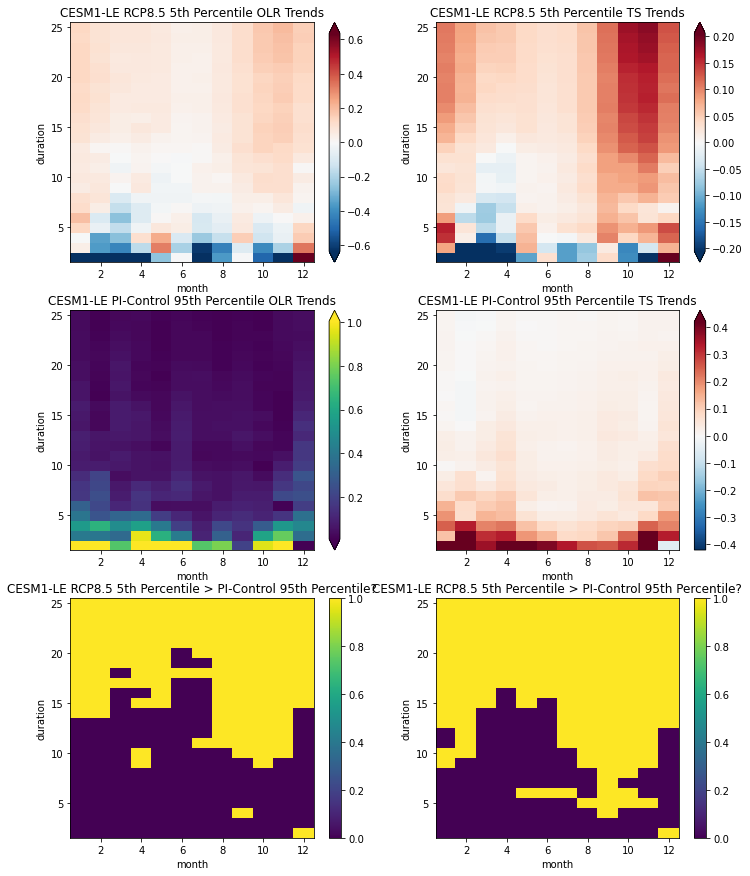

In [484]:
detc_fig,detc_axs = plt.subplots(nrows=3,ncols=2,figsize=(12,15))

olr_ens_5th_10_40.plot(ax=detc_axs[0,0],robust=True)
detc_axs[0,0].set_title('CESM1-LE RCP8.5 5th Percentile OLR Trends')

olr_pic_95th_10_40.plot(ax=detc_axs[1,0],robust=True)
detc_axs[1,0].set_title('CESM1-LE PI-Control 95th Percentile OLR Trends')

(olr_ens_5th_10_40>olr_pic_95th_10_40).plot(ax=detc_axs[2,0])
detc_axs[2,0].set_title('CESM1-LE RCP8.5 5th Percentile > PI-Control 95th Percentile?')

ts_ens_5th_10_40.plot(ax=detc_axs[0,1],robust=True)
detc_axs[0,1].set_title('CESM1-LE RCP8.5 5th Percentile TS Trends')

ts_pic_95th_10_40.plot(ax=detc_axs[1,1],robust=True)
detc_axs[1,1].set_title('CESM1-LE PI-Control 95th Percentile TS Trends')

(ts_ens_5th_10_40>ts_pic_95th_10_40).plot(ax=detc_axs[2,1])
detc_axs[2,1].set_title('CESM1-LE RCP8.5 5th Percentile > PI-Control 95th Percentile?')

In [346]:
# confidence=0.90

x = np.random.normal(size=100)

# values = [np.random.choice(x,size=len(x),replace=True).mean() for i in range(1000)] 

# # print(np.percentile(values,[100*(1-confidence)/2,100*(1-(1-confidence)/2)]))
# print(np.percentile(values,[5,95]))

print(ttest_CI(x,5),ttest_CI(x,95))
print(bootstrap_CI(x,5),bootstrap_CI(x,95))

print(calc_CI(x,5,method='ttest'))
print(calc_CI(x,5,method='bootstrap'))
# array([-0.13559955, 0.26480175])

-0.38282814811089694 -0.0486791068140979
-0.38324399116076757 -0.057363319636341344
-0.38282814811089694
-0.38614432668877774


In [277]:
np.percentile(rand_dist,5)

-0.6450536605007325

In [319]:
ttest_CI(rand_dist,5)

-1.3342722171142891

In [320]:
np.mean(rand_dist)

0.384762299098795

(array([1., 0., 4., 4., 7., 8., 6., 6., 2., 2.]),
 array([-2.27470748, -1.78837191, -1.30203634, -0.81570077, -0.32936519,
         0.15697038,  0.64330595,  1.12964152,  1.61597709,  2.10231266,
         2.58864824]),
 <BarContainer object of 10 artists>)

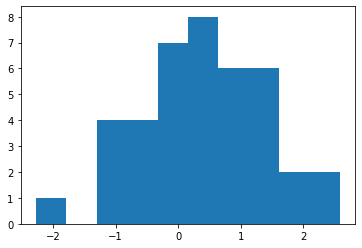

In [321]:
plt.hist(rand_dist)

In [317]:
bootstrap_CI(rand_dist,5)

0.13266755238093936

In [316]:
rand_dist = np.random.normal(loc=0.0, scale=1.0, size=int(40))

FLUT
TS
FLUT
TS
FLUT
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.
TS
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.


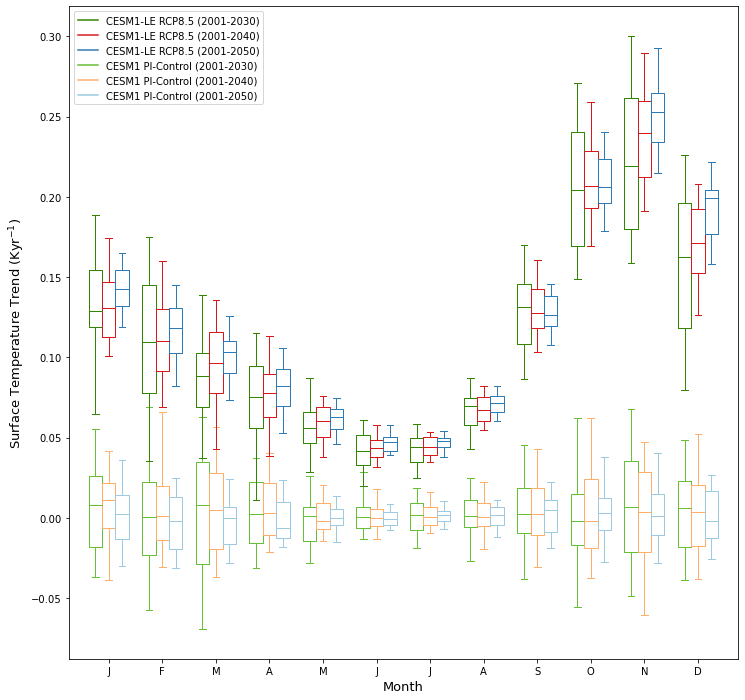

In [213]:
# Raw timeseries data
lens_tseries = allens_var_dict['TS']
obs_tseries = ceres_subset_spatavg

# Calculate PI-Control timeseries
pic_tseries_2030 = pi_tseries_to_ens(pic_var_dict,tlength=30,nmembers=40)['TS']
pic_tseries_2040 = pi_tseries_to_ens(pic_var_dict,tlength=40,nmembers=40)['TS']
pic_tseries_2050 = pi_tseries_to_ens(pic_var_dict,tlength=50,nmembers=40)['TS']

tsel_2030 = slice('2001-01-01','2030-12-31')
tsel_2040 = slice('2001-01-01','2040-12-31')
tsel_2050 = slice('2001-01-01','2050-12-31')

lens_tseries_2030 = lens_tseries.sel(time=tsel_2030)
lens_tseries_2040 = lens_tseries.sel(time=tsel_2040)
lens_tseries_2050 = lens_tseries.sel(time=tsel_2050)
obs_tseries_2021 = obs_tseries.sel(time=tsel_2021)

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
box_fig,box_ax = plt.subplots(1,1,figsize=(12,12)) # create your own axis if not supplied

obs_slopes_2021 = []
lens_slopes_dict_2030 = {}
lens_slopes_dict_2040 = {}
lens_slopes_dict_2050 = {}
pic_slopes_dict_2030 = {}
pic_slopes_dict_2040 = {}
pic_slopes_dict_2050 = {}

# Run a linear fit for each month for each ensemble member
ens_linfit_2030 = lens_tseries_2030.groupby('time.month').map(linear_polyfit)
ens_linfit_2040 = lens_tseries_2040.groupby('time.month').map(linear_polyfit)
ens_linfit_2050 = lens_tseries_2050.groupby('time.month').map(linear_polyfit)
pic_linfit_2030 = pic_tseries_2030.groupby('time.month').map(linear_polyfit)
pic_linfit_2040 = pic_tseries_2040.groupby('time.month').map(linear_polyfit)
pic_linfit_2050 = pic_tseries_2050.groupby('time.month').map(linear_polyfit)
obs_linfit_2021 = obs_tseries_2021.groupby('time.month').map(linear_polyfit)

ens_slopes_2030 = ens_linfit_2030['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2040 = ens_linfit_2040['polyfit_coefficients'].sel(degree=1)#.values
ens_slopes_2050 = ens_linfit_2050['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2030 = pic_linfit_2030['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2040 = pic_linfit_2040['polyfit_coefficients'].sel(degree=1)#.values
pic_slopes_2050 = pic_linfit_2050['polyfit_coefficients'].sel(degree=1)#.values
obs_slopes_2021 = obs_linfit_2021['polyfit_coefficients'].sel(degree=1)#.values

# Plot the model distributions as boxplots

# Start with PI-Control
# box_pic_2021 = box_ax.boxplot(pic_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_pic_2030 = box_ax.boxplot(pic_slopes_2030,  positions=np.arange(1,13)-0.25,widths=0.25,whis=(5,95),showfliers=False)
box_pic_2040 = box_ax.boxplot(pic_slopes_2040,  positions=np.arange(1,13),widths=0.25,whis=(5,95),showfliers=False)
box_pic_2050 = box_ax.boxplot(pic_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.25,whis=(5,95),showfliers=False)

set_box_color(box_pic_2030,'#66BF34')
set_box_color(box_pic_2040,'#FDAE6B')
set_box_color(box_pic_2050,'#9ECAE1')

# Now do RCP8.5
# box_ens_2021 = box_ax.boxplot(ens_slopes_2021,  positions=np.arange(1,13)-0.25,widths=0.4,whis=(0,100))
# box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.4,whis=(0,100))
box_ens_2030 = box_ax.boxplot(ens_slopes_2030,  positions=np.arange(1,13)-0.25,widths=0.25,whis=(5,95),showfliers=False)
box_ens_2040 = box_ax.boxplot(ens_slopes_2040,  positions=np.arange(1,13),widths=0.25,whis=(5,95),showfliers=False)
box_ens_2050 = box_ax.boxplot(ens_slopes_2050, labels=month_labels, positions=np.arange(1,13)+0.25,widths=0.25,whis=(5,95),showfliers=False)

set_box_color(box_ens_2030, '#318500')
set_box_color(box_ens_2040, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(box_ens_2050, '#2C7BB6')

# Plot observations as a scatterplot
# box_ax.scatter(np.arange(1,13,1)-0.25,obs_slopes_2021,label='CERES Obs. (2001-2021)',marker='*',color='yellow',edgecolors= "black",s=150) # update label here

box_ax.set_xlabel('Month',fontsize=13)
box_ax.set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=13) # fix

box_ax.set_xticks(np.arange(1,13,1))
box_ax.set_xticklabels(month_labels)
# box_ax.set_ylim((-0.2,0.6))

# draw temporary red and blue lines and use them to create a legend
box_ax.plot([], c='#318500', label='CESM1-LE RCP8.5 (2001-2030)')
box_ax.plot([], c='#D7191C', label='CESM1-LE RCP8.5 (2001-2040)')
box_ax.plot([], c='#2C7BB6', label='CESM1-LE RCP8.5 (2001-2050)')

box_ax.plot([], c='#66BF34', label='CESM1 PI-Control (2001-2030)')
box_ax.plot([], c='#FDAE6B', label='CESM1 PI-Control (2001-2040)')
box_ax.plot([], c='#9ECAE1', label='CESM1 PI-Control (2001-2050)')

box_ax.legend()

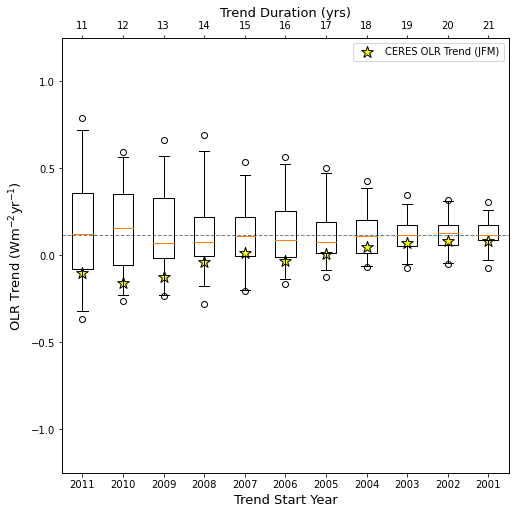

In [27]:
box_n_whisker_endyear(allens_jfm_tseries,
                      ceres_subset_jfmavg,
                      iter_yrs=startyrs[::-1],
                      iteryr_isstart=True,
                      ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                      obslabel='CERES OLR Trend (JFM)',
                      whis=(1, 99)
                     )

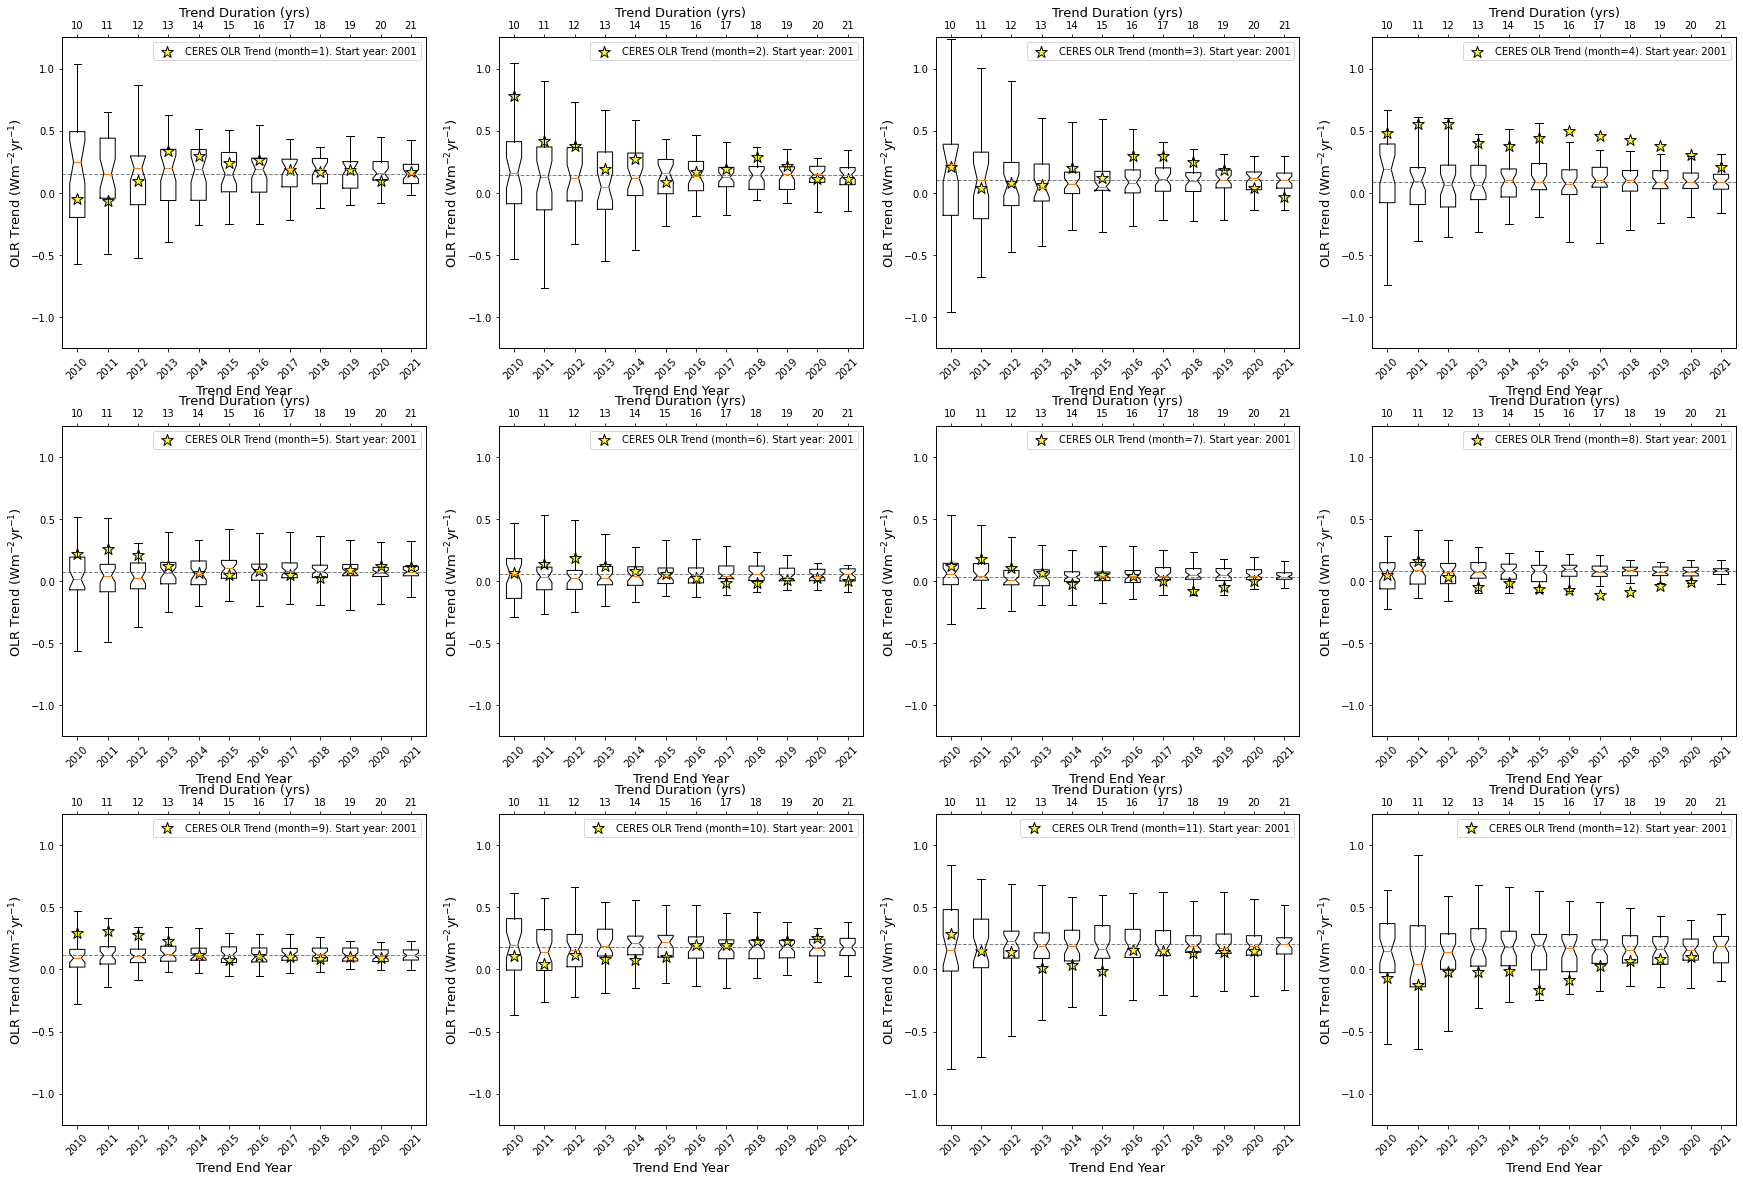

In [151]:
box_multi_fig,box_multi_axs = plt.subplots(nrows=3,ncols=4,figsize=(30,20)) #,sharex=True
box_multi_axs = box_multi_axs.flat

tsel = slice('2001-01-01','2021-12-31')

for i_mon,_ax in zip(range(1,13),box_multi_axs): # iterate over month numbers
    
    allens_all_tseries_preproc = allens_all_tseries.sel(time=tsel)
    ceres_subset_spatavg_preproc = ceres_subset_spatavg.sel(time=tsel)
    
    # _lens_mon_tseries = allens_all_tseries.sel(time=allens_all_tseries['time.month']==i_mon).groupby('time.year').mean('time')
    _lens_mon_tseries = allens_all_tseries_preproc.sel(time=allens_all_tseries_preproc['time.month']==i_mon).groupby('time.year').mean('time')
    # _obs_mon_tseries = ceres_subset_spatavg.sel(time=ceres_subset_spatavg['time.month']==i_mon).groupby('time.year').mean('time')
    _obs_mon_tseries = ceres_subset_spatavg_preproc.sel(time=ceres_subset_spatavg_preproc['time.month']==i_mon).groupby('time.year').mean('time')
        
    box_n_whisker_endyear(_lens_mon_tseries,
                          _obs_mon_tseries,
                          iter_yrs=endyrs,
                          iteryr_isstart=False,
                          ax=_ax,
                          ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                          obslabel='CERES OLR Trend (month=%d). Start year: 2001' % i_mon,
                          whis=(0, 100),
                          notch=True
                         )
    
plt.subplots_adjust(hspace=0.25)

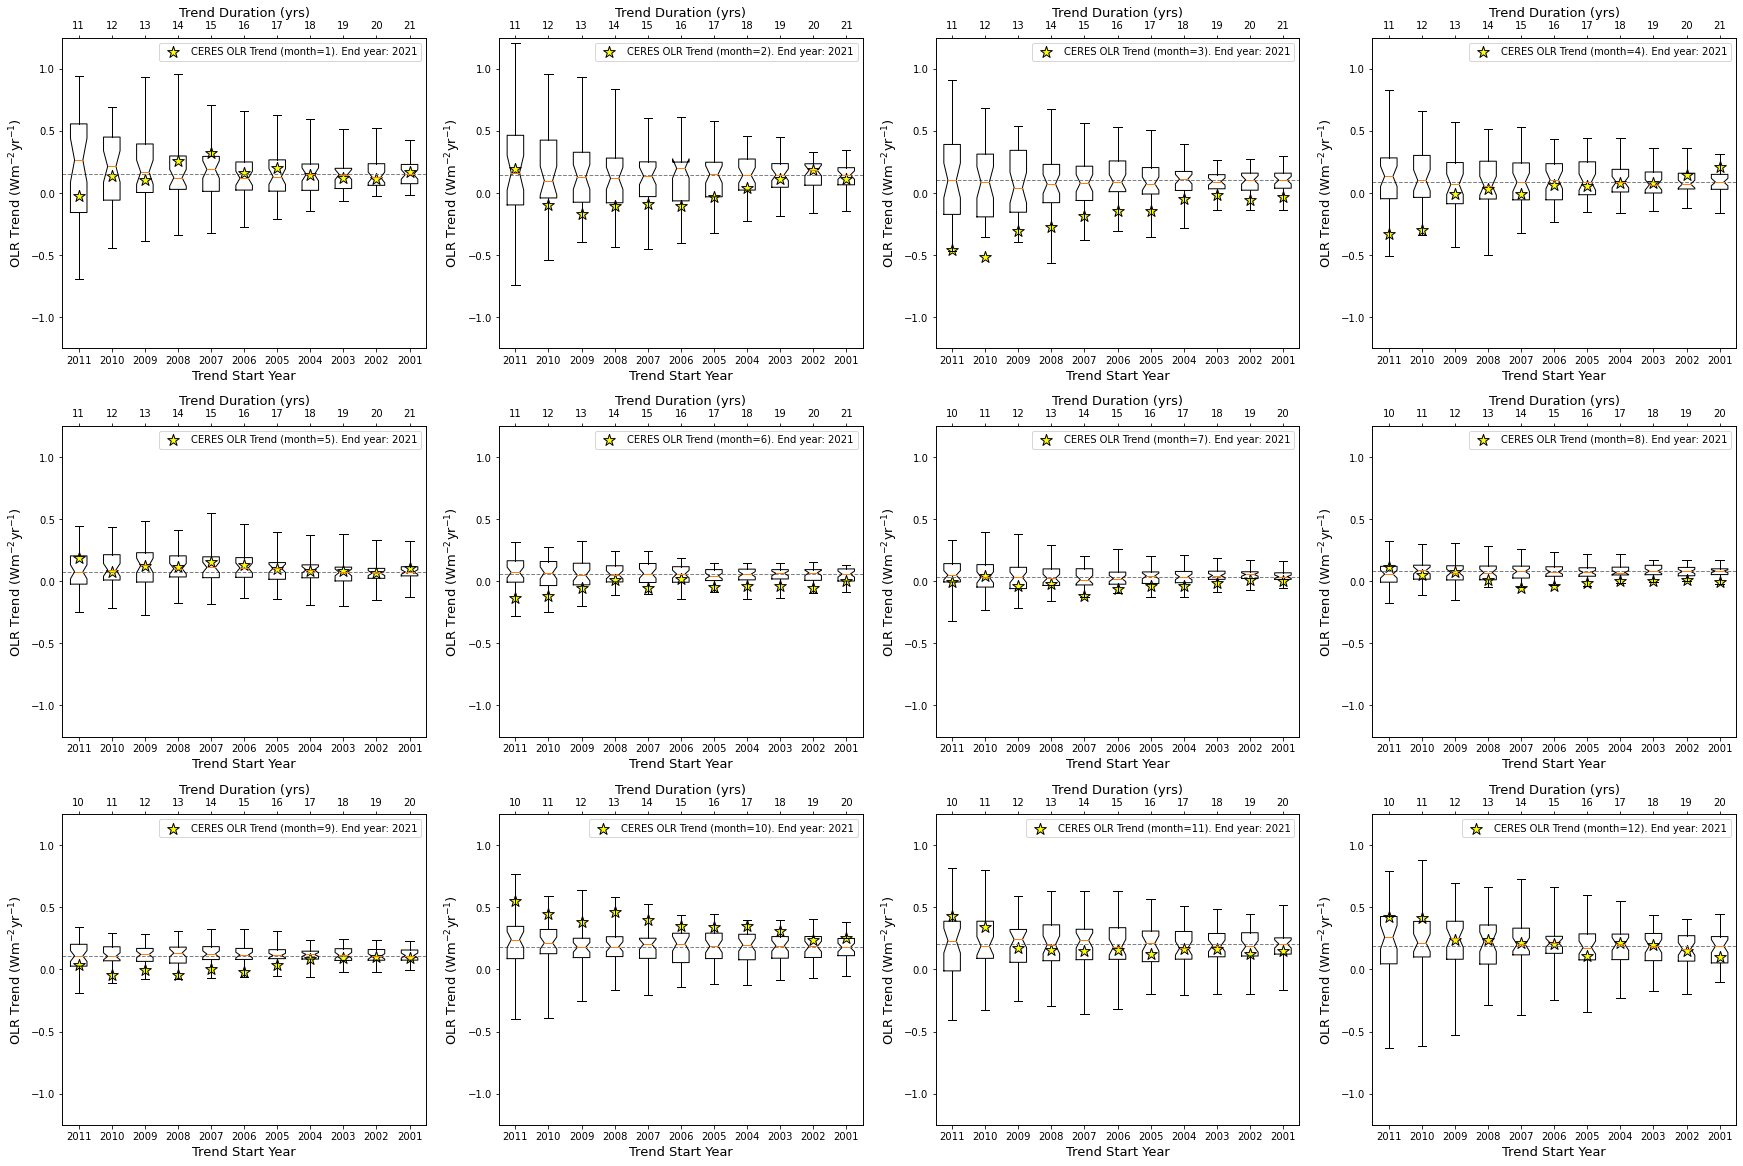

In [30]:
box_multi_fig,box_multi_axs = plt.subplots(nrows=3,ncols=4,figsize=(30,20)) #,sharex=True
box_multi_axs = box_multi_axs.flat

tsel = slice('2001-01-01','2021-12-31')

for i_mon,_ax in zip(range(1,13),box_multi_axs): # iterate over month numbers

    allens_all_tseries_preproc = allens_all_tseries.sel(time=tsel)
    ceres_subset_spatavg_preproc = ceres_subset_spatavg.sel(time=tsel)
    
    # _lens_mon_tseries = allens_all_tseries.sel(time=allens_all_tseries['time.month']==i_mon).groupby('time.year').mean('time')
    _lens_mon_tseries = allens_all_tseries_preproc.sel(time=allens_all_tseries_preproc['time.month']==i_mon).groupby('time.year').mean('time')
    # _obs_mon_tseries = ceres_subset_spatavg.sel(time=ceres_subset_spatavg['time.month']==i_mon).groupby('time.year').mean('time')
    _obs_mon_tseries = ceres_subset_spatavg_preproc.sel(time=ceres_subset_spatavg_preproc['time.month']==i_mon).groupby('time.year').mean('time')
    
    box_n_whisker_endyear(_lens_mon_tseries,
                          _obs_mon_tseries,
                          iter_yrs=startyrs[::-1],
                          iteryr_isstart=True,
                          ax=_ax,
                          ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                          obslabel='CERES OLR Trend (month=%d). End year: 2021' % i_mon,
                          whis=(0,100),
                          notch=True
                         )
    
plt.subplots_adjust(hspace=0.25)

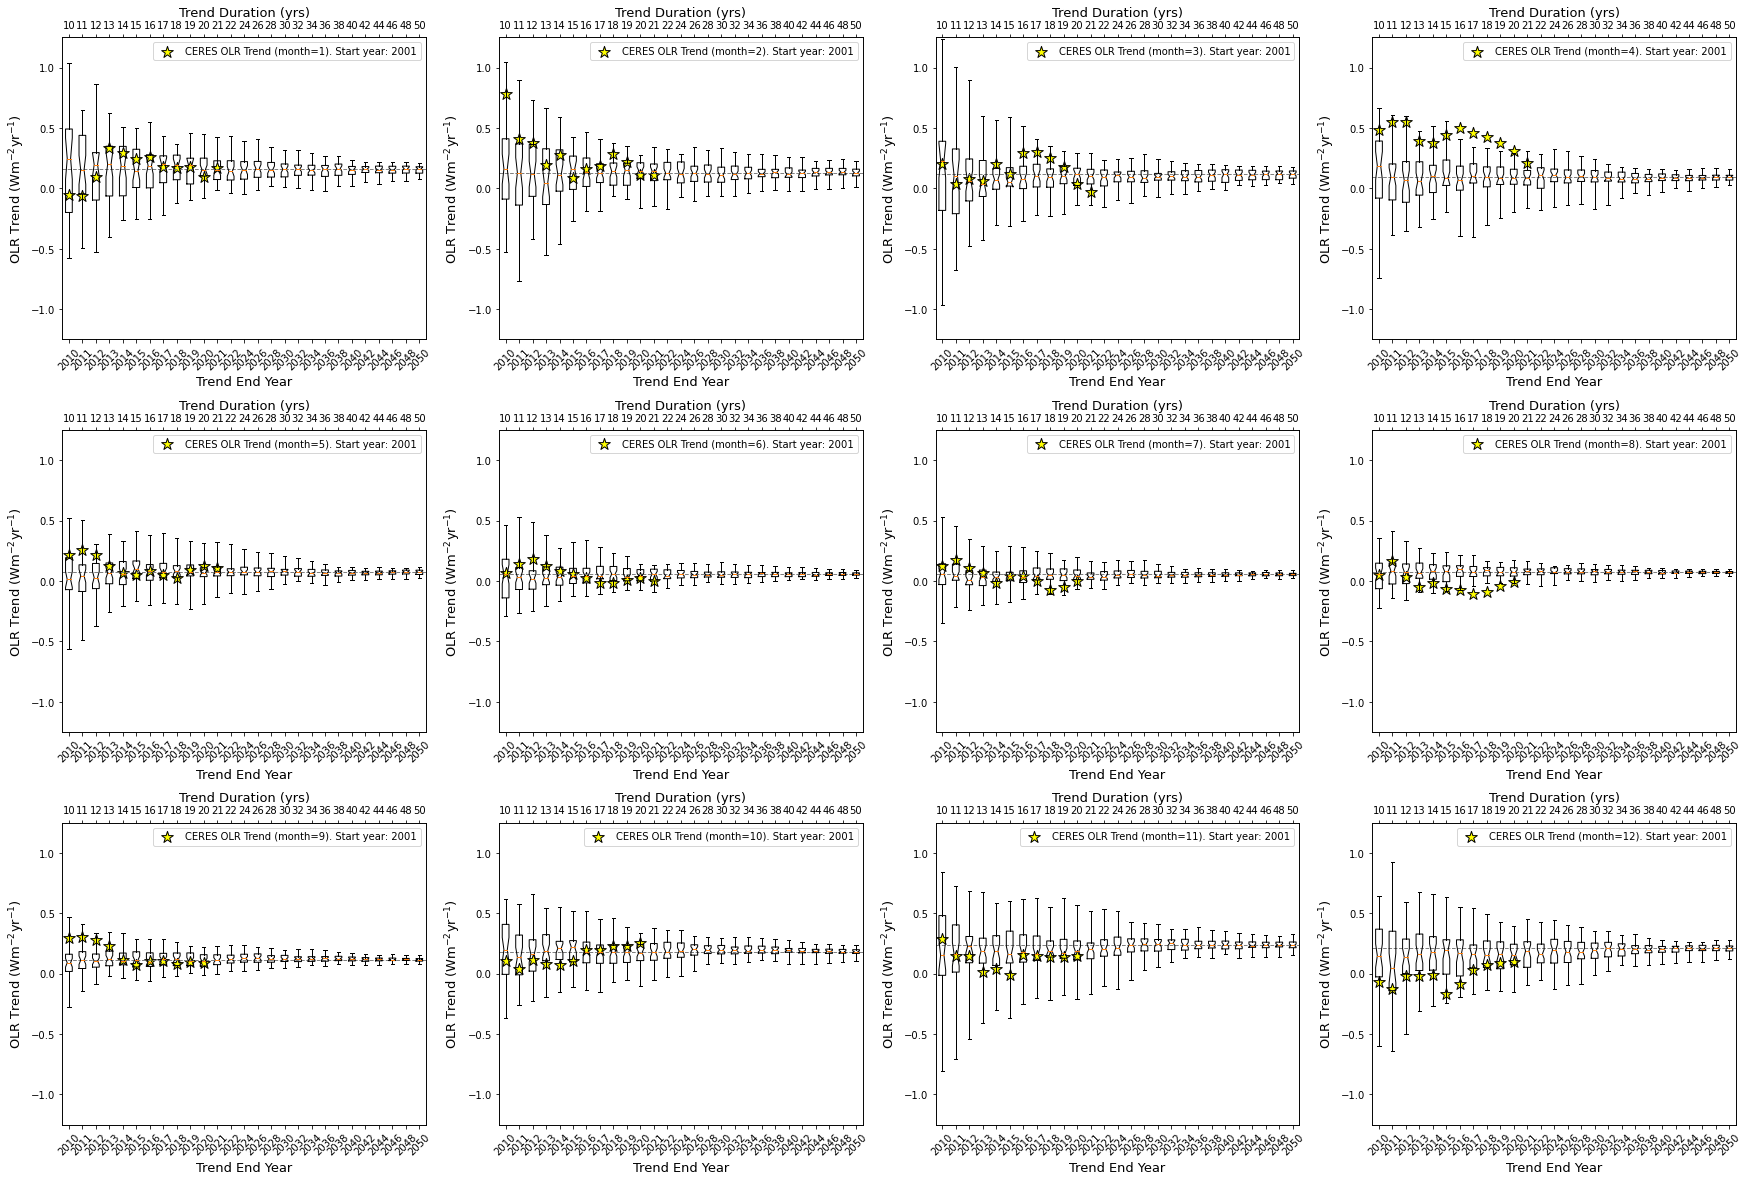

In [152]:
box_multi_fig,box_multi_axs = plt.subplots(nrows=3,ncols=4,figsize=(30,20)) #,sharex=True
box_multi_axs = box_multi_axs.flat

tsel = slice('2001-01-01','2021-12-31')
endyrs_ext = np.append(np.arange(2010,2022,1),np.arange(2022,2051,2))
# np.arange(2010,2051,1)

for i_mon,_ax in zip(range(1,13),box_multi_axs): # iterate over month numbers
    
    allens_all_tseries_preproc = allens_all_tseries#.sel(time=tsel)
    ceres_subset_spatavg_preproc = ceres_subset_spatavg#.sel(time=tsel)
    
    # _lens_mon_tseries = allens_all_tseries.sel(time=allens_all_tseries['time.month']==i_mon).groupby('time.year').mean('time')
    _lens_mon_tseries = allens_all_tseries_preproc.sel(time=allens_all_tseries_preproc['time.month']==i_mon).groupby('time.year').mean('time')
    # _obs_mon_tseries = ceres_subset_spatavg.sel(time=ceres_subset_spatavg['time.month']==i_mon).groupby('time.year').mean('time')
    _obs_mon_tseries = ceres_subset_spatavg_preproc.sel(time=ceres_subset_spatavg_preproc['time.month']==i_mon).groupby('time.year').mean('time')
        
    box_n_whisker_endyear(_lens_mon_tseries,
                          _obs_mon_tseries,
                          iter_yrs=endyrs_ext,
                          iteryr_isstart=False,
                          ax=_ax,
                          ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                          obslabel='CERES OLR Trend (month=%d). Start year: 2001' % i_mon,
                          whis=(0, 100),
                          notch=True
                         )
    
plt.subplots_adjust(hspace=0.30)

In [ ]:
box_multi_fig,box_multi_axs = plt.subplots(nrows=3,ncols=4,figsize=(30,20)) #,sharex=True
box_multi_axs = box_multi_axs.flat

tsel = slice('2001-01-01','2021-12-31')
# startyrs_ext = np.append(np.arange(2010,2022,1),np.arange(2022,2051,2))
# np.arange(2010,2051,1)

for i_mon,_ax in zip(range(1,13),box_multi_axs): # iterate over month numbers
    
    allens_all_tseries_preproc = allens_all_tseries#.sel(time=tsel)
    ceres_subset_spatavg_preproc = ceres_subset_spatavg#.sel(time=tsel)
    
    # _lens_mon_tseries = allens_all_tseries.sel(time=allens_all_tseries['time.month']==i_mon).groupby('time.year').mean('time')
    _lens_mon_tseries = allens_all_tseries_preproc.sel(time=allens_all_tseries_preproc['time.month']==i_mon).groupby('time.year').mean('time')
    # _obs_mon_tseries = ceres_subset_spatavg.sel(time=ceres_subset_spatavg['time.month']==i_mon).groupby('time.year').mean('time')
    _obs_mon_tseries = ceres_subset_spatavg_preproc.sel(time=ceres_subset_spatavg_preproc['time.month']==i_mon).groupby('time.year').mean('time')
        
    box_n_whisker_endyear(_lens_mon_tseries,
                          _obs_mon_tseries,
                          iter_yrs=startyrs,
                          iteryr_isstart=True,
                          ax=_ax,
                          ylabel='OLR Trend (Wm$^{-2}$yr$^{-1}$)',
                          obslabel='CERES OLR Trend (month=%d). Start year: 2001' % i_mon,
                          whis=(0, 100),
                          notch=True
                         )
    
plt.subplots_adjust(hspace=0.30)

# Old Dask stuff that didn't work

https://docs.dask.org/en/latest/delayed-best-practices.html

"working?" Dask approach. Breaks when I actually run it with multiple workers.

In [33]:
# %%time

# @dask.delayed
# def load_ens(path_dict,_ens_num):
    
#     _ens_olr_files = path_dict[_ens_num]
#     _ens_olr_ds = fix_cesm_time(xr.open_mfdataset(_ens_olr_files))['FLUT'].chunk({'lat':-1,'lon':-1}) # chunk to prep for lat-lon interpolation
#     # ^is this bad that I am opening a dask object within a .delayed call? No?
    
#     return _ens_olr_ds

# @dask.delayed
# def process_ens(_ens_olr_ds,_interp_latlon):
    
#     _ens_interp = _ens_olr_ds.interp_like(_interp_latlon.isel(time=0)) # interpolate before subsetting, could use xESMF
#     _ens_olr_ds.close()
#     _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))
#     _ens_subset.close()
#     _ens_subset_wgtd = add_weights(_ens_subset) # add area-weighting coordinate
#     _ens_subset.close()
#     _ens_subset_spatavg = masked_average(_ens_subset_wgtd,dim=['lat','lon'],weights=_ens_subset_wgtd['cell_weight'])
#     _ens_subset_wgtd.close()
    
#     return _ens_subset_spatavg

# @dask.delayed
# def compute_ens(_ens_subset_spatavg,_ens_num):
    
#     _ens_subset_jfm = _ens_subset_spatavg.sel(time=is_jfm(_ens_subset_spatavg.time)) # select jan, feb, mar
#     _ens_subset_ond = _ens_subset_spatavg.sel(time=is_ond(_ens_subset_spatavg.time)) # select jan, feb, mar
#     _ens_subset_jfmavg = _ens_subset_jfm.groupby('time.year').mean('time') #.compute() # average into an annual timeseries, compute to avoid chunkng
#     _ens_subset_ondavg = _ens_subset_ond.groupby('time.year').mean('time') #.compute() # average into an annual timeseries, compute to avoid chunkng
#     _ens_subset_jfm.close()
#     _ens_subset_ond.close()
#     _ens_subset_monavg = _ens_subset_spatavg.groupby('time.month').mean('time') #.compute() # monthly OLR averages over the CERES record
#     _ens_subset_spatavg.close()
    
#     _ens_subset_jfmavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
#     _ens_subset_ondavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
#     _ens_subset_monavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    
#     return _ens_subset_jfmavg,_ens_subset_monavg,_ens_subset_ondavg

# def f(path_dict,ensemble_nums):
#     # results = []
#     results = {}
#     for _ens_num in ensemble_nums:
#         # print(_ens_num)
#         data = load_ens(path_dict,_ens_num)
#         data = process_ens(data,ceres_subset)
#         result = compute_ens(data,_ens_num)

#         # results.append(result)
#         results[_ens_num] = result
        
#         # if _ens_num == '005':break

#     return results

In [34]:
# %%time

# preresults = f(path_dict,ensemble_nums)

In [35]:
# %%time

# results = dask.compute(preresults)[0]

#### Post-process into a ensemble-combined format

Only do if the dask approach is fixed.

In [36]:
ens_olr_jfm_tseries_list = []
ens_olr_ond_tseries_list = []
ens_olr_mon_tseries_list = []

for _ens_num in ensemble_nums:
    ens_olr_jfm_tseries_list.append(results[_ens_num][0])
    ens_olr_ond_tseries_list.append(results[_ens_num][0])
    ens_olr_mon_tseries_list.append(results[_ens_num][1])
    
allens_jfm_tseries = xr.concat(ens_olr_jfm_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})
allens_ond_tseries = xr.concat(ens_olr_ond_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})
allens_mon_tseries = xr.concat(ens_olr_mon_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})

NameError: name 'results' is not defined

In [ ]:
allens_jfm_tseries = xr.concat(list(ens_olr_jfm_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
allens_ond_tseries = xr.concat(list(ens_olr_ond_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
allens_mon_tseries = xr.concat(list(ens_olr_mon_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})